# Ride Along with Lucy!

In this notebook we'll examine the trajectory of the Lucy spacecraft itself. We'll look at its complicated orbit and show that we can correcttly predict its encounters. We'll also compute its trajectory after its last scheduled encounter with the equal-mass L5 binary Patroclus/Menoetius on March 3, 2033. In the homework, you will investigate the possibility encountering additional objects.

In [1]:
from spacerocks.spacerock import SpaceRock, Units
from spacerocks.simulation import Simulation
from spacerocks.model import PerturberModel, builtin_models
from spacerocks.units import Units
from spacerocks.spice import SpiceBody, SpiceKernel
from spacerocks.utils import time_handler


import numpy as np
import pandas as pd
from astropy import units as u
from astropy.time import Time

import matplotlib.pyplot as plt
%matplotlib inline

NASA (and many other space agencies) use a tool called [SPICE](https://naif.jpl.nasa.gov/naif/index.html) to describe the trajectory, maneuvers, and operational parameters of a spacecraft.  Most commonly these are encoded into a file called a SPICE kernel. You can find the one for Lucy [here](https://naif.jpl.nasa.gov/pub/naif/LUCY/kernels/). The set of software tools for working with SPICE files is called the [SPICE toolkit](https://naif.jpl.nasa.gov/naif/toolkit.html). While making full use of its capabilities involves a very non-trivial learning curve (the mastery of which would qualify you to be a NASA flight engineer), `spacerocks` provides us with an interface that's good enough for our purposes while hiding a lot of the details under the hood.

Let's read the Lucy kernel into our software framework.

In [2]:
epoch = time_handler('October 17, 2021').utc.jd # We'll begin the day after Lucy was launched.

kernel = SpiceKernel()
kernel.spk += ["../spice/lcy_211016_330403_230131_OD032-R-TCM08a-P-TCM36-P_v1.bsp"]
kernel.furnsh()

lucy_spice = SpiceBody(spiceid="Lucy", kernel=kernel)

Now we'll build a full-scale model of the solar system including the Lucy targets.

In [3]:
units = Units()
units.timescale = 'tdb' 
units.mass = u.M_sun

spiceids, kernel, _ = builtin_models['HORIZONS']
model = PerturberModel(spiceids=spiceids, kernel=kernel)
sim = Simulation(model=model,  epoch=epoch, units=units)
sim.dt = 1
sim.integrator = 'ias15'


# Add the other Lucy targets
Lucy_targets = ['Eurybates', 'Polymele','Leucus', 'Orus', 'Patroclus']
for target in Lucy_targets:
    rock = SpaceRock.from_horizons(target)    # grab their orbital elements from JPL Horizons
    sim.add_spacerocks(rock)                  # add them to our simulation

In [4]:
# Some test synthetic targets
'''
df = pd.read_csv('encounterable_clones/trojans_1.csv')
units = Units()
units.timescale = 'tt'
units.timeformat = 'jd'
epoch = df.epoch
M = df.M
arg = df.arg
node = df.node
inc = df.inc
e = df.e
a = df.a
name=df.name
trojans = SpaceRock(a=a, e=e, inc=inc, arg=arg, node=node, M=M,
                    epoch=epoch, name=name, units=units, origin='sun')

sim.add_spacerocks(trojans)
'''

"\ndf = pd.read_csv('encounterable_clones/trojans_1.csv')\nunits = Units()\nunits.timescale = 'tt'\nunits.timeformat = 'jd'\nepoch = df.epoch\nM = df.M\narg = df.arg\nnode = df.node\ninc = df.inc\ne = df.e\na = df.a\nname=df.name\ntrojans = SpaceRock(a=a, e=e, inc=inc, arg=arg, node=node, M=M,\n                    epoch=epoch, name=name, units=units, origin='sun')\n\nsim.add_spacerocks(trojans)\n"

Next we'll integrate our model solar system (the Horizons model, which includes the major planets and large asteroids), plus the Lucy targets we added, between the Lucy launch date and shortly after last projected encounter in March, 2033:

In [5]:
t_start = Time('2021-10-17', format='iso', scale='tdb')
t_end = Time('2033-04-01', format='iso', scale='tdb')
epochs = np.arange(t_start.jd, t_end.jd, 2)

In [6]:
prop, planets, _ = sim.propagate(epochs=epochs, units=units, exact_finish_time=1)

Output()

The integration we just performed does not include the Lucy spacecraft itself. That's because Lucy isn't a passive body -- it is engaging in maneuvers throughout the mission duration to optimize the approach to its targets. Fortunately these are precisely what the SPICE kernel is intended to model. In the next cell we use the SPICE kernel we read in above to compute Lucy's position and velocity at each epoch.

In [7]:
lucy_x, lucy_y, lucy_z = np.zeros(len(epochs)), np.zeros(len(epochs)), np.zeros(len(epochs))
lucy_vx, lucy_vy, lucy_vz = np.zeros(len(epochs)), np.zeros(len(epochs)), np.zeros(len(epochs))
lucy_t = np.zeros(len(epochs))
for i, epoch in enumerate(epochs):
    try:
        lucy = lucy_spice.at(epoch)
        lucy_x[i]= lucy.x.au
        lucy_y[i] = lucy.y.au
        lucy_z[i] = lucy.z.au
        lucy_vx[i]= lucy.vx[0].value
        lucy_vy[i] = lucy.vy[0].value
        lucy_vz[i] = lucy.vz[0].value
        lucy_t[i] = epoch
    except:
        t_err = Time(epoch, format='jd', scale='tdb')
        print(f'Spice error at epoch {epoch} = {t_err.iso}')


Spice error at epoch 2460248.5 = 2023-10-31 00:00:00.000
Spice error at epoch 2460250.5 = 2023-11-02 00:00:00.000
Spice error at epoch 2460252.5 = 2023-11-04 00:00:00.000
Spice error at epoch 2460786.5 = 2025-04-21 00:00:00.000
Spice error at epoch 2461628.5 = 2027-08-11 00:00:00.000
Spice error at epoch 2461630.5 = 2027-08-13 00:00:00.000
Spice error at epoch 2461662.5 = 2027-09-14 00:00:00.000
Spice error at epoch 2461664.5 = 2027-09-16 00:00:00.000
Spice error at epoch 2461880.5 = 2028-04-19 00:00:00.000
Spice error at epoch 2462086.5 = 2028-11-11 00:00:00.000
Spice error at epoch 2462088.5 = 2028-11-13 00:00:00.000
Spice error at epoch 2463660.5 = 2033-03-04 00:00:00.000


The above procedure produced errors on several specific dates. These are near the dates of specific encounters, and I suspect that the basic SPICE kernel we loaded needs to be supplemented with additional data from some of the many other SPICE kernels available for Lucy.  Until I figure out how to do that, we'll simply ignore those errors and focus on the rest of the trajectory.

Now let's have a look at Lucy's trajectory.

In [10]:
# save the state of Lucy at the final epoch above, we will need this to compute its trajectory beyond the mission end date.
print(f"Last time computed: {Time(epoch, format='jd', scale='tdb').iso}")
lucy_spacerock = lucy_spice.at(epoch)

Last time computed: 2033-03-30 00:00:00.000


In [11]:
jup = planets[planets.name=="Jupiter Barycenter"]
earth = planets[planets.name=="Earth"]

In [12]:
# As we did in the Trojan Dynamics notebook, we'll move to
# Jupiter's co-rotating frame
jup_angle = jup.true_longitude 
rot = jup_angle - jup_angle[0] # Jupiter rotates through this angle for each step

x_jup = jup.x.au * np.cos(-rot) - jup.y.au * np.sin(-rot)
y_jup = jup.x.au * np.sin(-rot) + jup.y.au * np.cos(-rot)
x_lucy = lucy_x * np.cos(-rot) - lucy_y * np.sin(-rot)
y_lucy = lucy_x * np.sin(-rot) + lucy_y * np.cos(-rot)
x_earth = earth.x * np.cos(-rot) - earth.y * np.sin(-rot)
y_earth = earth.x * np.sin(-rot) + earth.y * np.cos(-rot)

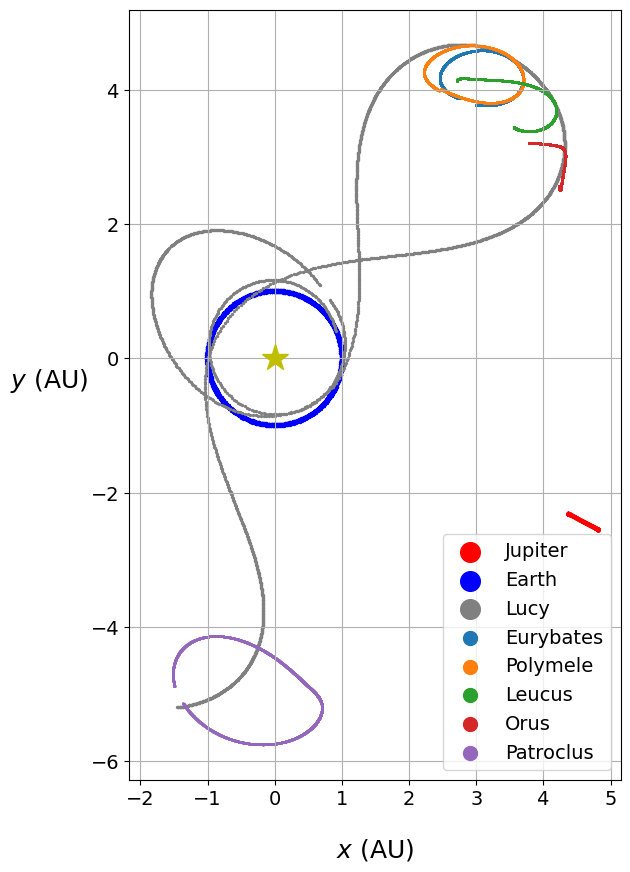

In [16]:
# Plot positions in Jupiter's co-rotating frame
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(0, 0, '*', markersize=20, color='y',)
ax.scatter(x_jup, y_jup, s=2, color='red', label ='Jupiter')
ax.scatter(x_earth, y_earth, s=2, color='b', label ='Earth')
ax.scatter(x_lucy, y_lucy, s=2, color='grey', label='Lucy')
for target in Lucy_targets:
    ast = prop[prop.name==target]
    x_ast = ast.x.au * np.cos(-rot) - ast.y.au * np.sin(-rot)
    y_ast = ast.x.au * np.sin(-rot) + ast.y.au * np.cos(-rot)
    ax.scatter(x_ast, y_ast, s=1, label=ast.name[0])

ax.legend(fontsize=14, markerscale=10)
ax.tick_params(labelsize=14)
ax.set_xlabel(r'$x$ (AU)', fontsize=18, labelpad=20)
ax.set_ylabel(r'$y$ (AU)', fontsize=18, labelpad=30, rotation=0)
ax.grid()
ax.set_aspect('equal')
plt.savefig('Lucy-corotating.png')

This plot shows Lucy's fascinating trajectory. The sun is at the center (0,0), and Earth is the circle with a radius of 1 AU. Jupiter is the short line near (4.5,-2). It its own co-rotating frame, Jupiter just moved radially in and out due to its slightly eccentric orbit. The L4 targets are at the upper right, and the L5 target is at the lower left. During the 11.5-year period of this integration, Jupiter executes nearly one complete orbit, and the Trojan asteroids complete nearly one full loop near their Lagrange point.

You can also see indications of the three earth gravity assists that boost Lucy from its initial ~1 year orbit to its final trajectory through the Trojans. Note that to travel from L4 to L5, Lucy will re-enter the inner solar system and pass inside Earth's orbit.

At the end of its mission, Lucy will be just another object orbiting the sun. Here are some of its orbital elements:

In [17]:
lucy_epoch = Time(epochs[-1], format='jd', scale='tdb')

print(f"At epoch {lucy_epoch.iso}, Lucy's (a, e, i) are {round(lucy_spacerock.a.au[-1],3)} AU, {round(lucy_spacerock.e[-1],3)}, "
      f"{round(lucy_spacerock.inc.deg[-1],3)} deg.")

At epoch 2033-03-30 00:00:00.000, Lucy's (a, e, i) are 3.29 AU, 0.712, 10.746 deg.


# Lucy beyond 2033

What will Lucy do next? For the near term (at least on solar system timescales), we can look over the next 100 years:

In [18]:
t_extended_start = Time('2033-04-01', format='iso', scale='tdb')
t_extended_end = Time('2133-04-01', format='iso', scale='tdb')
extended_epochs = np.arange(t_extended_start.jd, t_extended_end.jd, 10)

In [19]:
units = Units()
units.timescale = 'tdb' 
units.mass = u.M_sun

spiceids, kernel, _ = builtin_models['HORIZONS']
model = PerturberModel(spiceids=spiceids, kernel=kernel)
sim = Simulation(model=model,  epoch=epoch, units=units)
sim.dt = 1
sim.integrator = 'ias15'

sim.add_spacerocks(lucy_spacerock)

# Add the other Lucy targets
Lucy_targets = ['Eurybates', 'Polymele','Leucus', 'Orus', 'Patroclus']
for target in Lucy_targets:
    rock = SpaceRock.from_horizons(target)
    sim.add_spacerocks(rock)

/Users/gerdes/.local/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [20]:
prop, planets, _ = sim.propagate(epochs=extended_epochs, units=units, exact_finish_time=1)

Output()

In [21]:
lucy = prop[prop.name=="Lucy"]

In [22]:
lucy.epoch[-1].iso

'2133-03-28 00:00:00.000'

In [23]:
#get x, y positions in Jupiter's co-rotating frame 
jup = planets[planets.name=="Jupiter Barycenter"]

jup_angle = jup.true_longitude 
rot = jup_angle - jup_angle[0] # Jupiter rotates through this angle for each step 
x_jup = jup.x.au * np.cos(-rot) - jup.y.au * np.sin(-rot)
y_jup = jup.x.au * np.sin(-rot) + jup.y.au * np.cos(-rot)
x_lucy = lucy.x.au * np.cos(-rot) - lucy.y.au * np.sin(-rot)
y_lucy = lucy.x.au * np.sin(-rot) + lucy.y.au * np.cos(-rot)



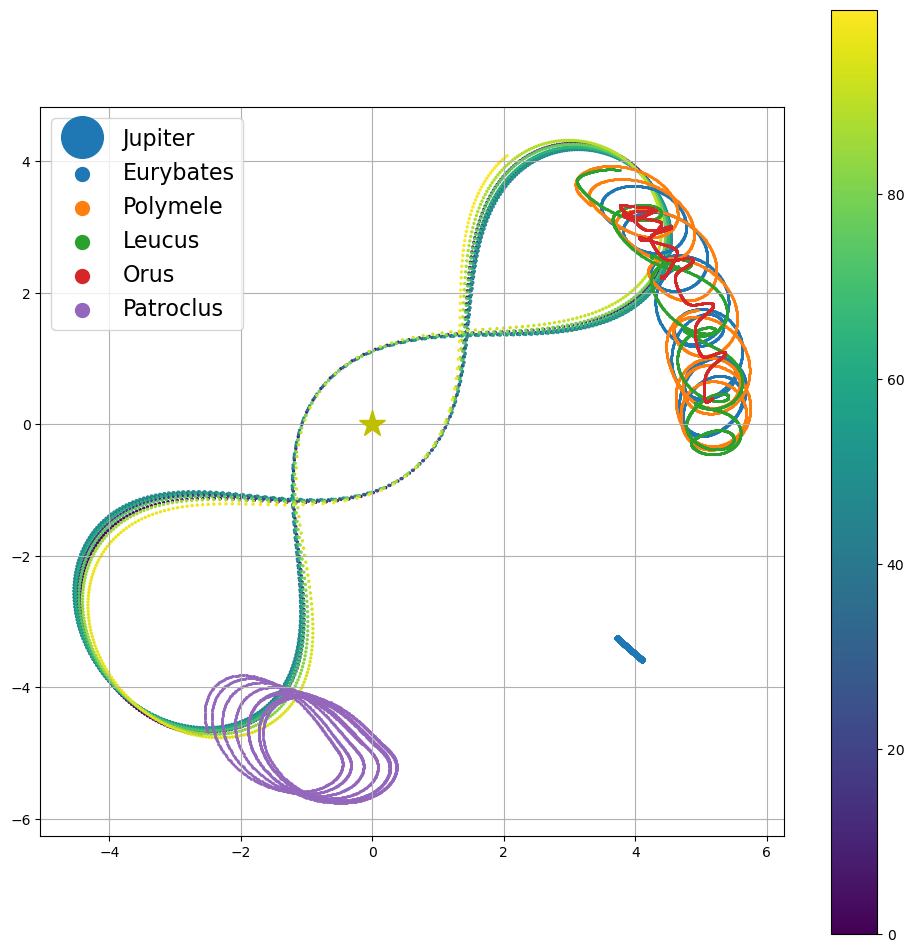

In [24]:
# Plot postions in Jupiter's co-rotating frame
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(0, 0, '*', markersize=20, color='y',)
ax.plot(x_jup, y_jup, '.', label ='Jupiter')
sc = ax.scatter(x_lucy, y_lucy, s=2, c=(lucy.epoch.mjd-lucy.epoch.mjd[0])/365.25)
for target in Lucy_targets:
    ast = prop[prop.name==target]
    x_ast = ast.x.au * np.cos(-rot) - ast.y.au * np.sin(-rot)
    y_ast = ast.x.au * np.sin(-rot) + ast.y.au * np.cos(-rot)
    ax.scatter(x_ast, y_ast, s=1, label=ast.name[0])
ax.grid()
ax.set_aspect('equal')
leg = ax.legend(fontsize=16, markerscale=10)
plt.savefig('Lucy_extended.png')
plt.colorbar(sc)

Evidently Lucy will simply remain on its final orbit for at least the next century, revisiting a Trojan cloud roughly every 6 years. This raises the possibility of additional encounters, if the spacecraft remains operational.


# Homework (due Friday 3/24)

While encounters in the decades beyond 2033 are of moderate interest, what about additional encounters on the present tour through the Trojans? In this exercise, you'll examine a synthetic sample of encounterable Trojans, and work out when and where to search for them. This is the kind of work that astronomers do when planning a discovery survey.

* In the `data` folder, you'll

In [36]:
t_encounter = Time(2463452.5, format='jd')
t_encounter.iso

'2032-08-08 00:00:00.000'